## Spectrophotometric calibration of Loa against Calspec

https://github.com/LSSTDESC/getCalspec/blob/main/README.md  
https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/calspec  
https://archive.stsci.edu/hlsps/reference-atlases/cdbs/calspec/

https://www.legacysurvey.org/viewer-desi?ra=199.0895607296073&dec=29.098075844257917&zoom=15&mark=199.08956249999997,29.098074999999998;199.09105417,29.09871667

https://inspector.desi.lbl.gov/loa/targets/2305843020102114059

John Moustakas  
Siena College  
2025 July 17

In [66]:
import os
import numpy as np
import fitsio
from astropy.table import Table, vstack, hstack, join
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
specprod = 'loa'
workdir = os.path.join(os.getenv('PSCRATCH'), f'calspec-{specprod}')
if not os.path.isdir(workdir):
    os.makedirs(workdir, exist_ok=True)

In [3]:
def read_calspec(overwrite=False):

    calspecfile =  os.path.join(workdir, 'calspec.fits')
    if not os.path.isfile(calspecfile) or overwrite:
        calspeccsv =  os.path.join(workdir, 'calspec.csv')
        if not os.path.isfile(calspeccsv):
            url = 'https://raw.githubusercontent.com/LSSTDESC/getCalspec/refs/heads/main/calspec_data/calspec.csv'
            os.system(f'wget -O {calspeccsv} {url}')
    
        cal = Table.read(calspeccsv)
        cal.rename_column('col0', 'row')
        cal.rename_column('RA', 'RA_hms')
        cal.rename_column('Decl', 'Dec_dms')
        cal = cal['row', 'Star_name', 'Sp_T', 'V', 'B_V', 'Name', 'Model', 'STIS', 'RA_hms', 'Dec_dms']
        print(f'Read {len(cal)} stars from {calspecfile}')

        c_cal = SkyCoord(ra=cal['RA_hms'], dec=cal['Dec_dms'], unit=(u.hourangle, u.deg))
        cal['RA'] = c_cal.ra.value
        cal['DEC'] = c_cal.dec.value
        cal.remove_columns(['RA_hms', 'Dec_dms'])
        cal.rename_columns(cal.colnames, [col.upper() for col in cal.colnames])

        if specprod == 'loa':
            # main-backup observations of 2305843020102114059 (=HZ43, a WD), incorrectly match to HZ43B (an M-type dwarf)
            print('Removing HZ43B!')
            cal.remove_row(np.where(cal['STAR_NAME'] == 'HZ43B')[0][0])
        
        cal.write(calspecfile, overwrite=True)
        print(f'Wrote {len(cal)} rows to {calspecfile}')
    else:
        cal = Table(fitsio.read(calspecfile))
        print(f'Read {len(cal)} rows from {calspecfile}')
        
    return cal        

In [18]:
sample = read_calspec(overwrite=False)
calspec_columns = sample.colnames
sample

Read 130 rows from /pscratch/sd/i/ioannis/calspec-loa/calspec.fits


ROW,STAR_NAME,SP_T,V,B_V,NAME,MODEL,STIS,RA,DEC
int64,str11,str11,str7,str5,str13,str8,str15,float64,float64
0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,221.5621875,1.8928833333333333
1,10 LAC,O9V,4.88,-0.21,10lac,_mod_005,_stis_007,339.8153291666666,39.05026944444444
2,16 CYG B,G3V,6.20,0.66,16cygb,_mod_004,_stis_004,295.46655416666664,50.517525
3,18 SCO,G2V,5.50,0.65,18sco,_mod_005,_stis_005,243.90529166666667,-8.36943888888889
4,1732526,A4V,12.53,0.12,1732526,_mod_005,_stisnic_007,263.21929166666666,71.07864444444444
5,1740346,A6V,12.48,0.20,1740346,,_stisnic_005,265.1444958333333,65.45410277777778
6,1743045,A8III,13.52,0.28,1743045,_mod_005,_stisnic_007,265.7686916666666,66.91712777777778
7,1757132,A3V,12.01,-0.10,1757132,_mod_005,_stiswfc_004,269.30513749999994,67.061325
8,1802271,A2V,11.53,0.02,1802271,_mod_005,_stiswfcnic_004,270.6131791666666,60.72653888888889


In [55]:
def match_zall_healpix(sample, maxsep=3*u.arcsec, specprod='loa', overwrite=False):
    """
    Gather all observations of each object by matching to zall-pix
    within MAXSEP.

    """
    outfile_healpix = os.path.join(workdir, f'calspec-healpix-{specprod}.fits')

    if not os.path.isfile(outfile_healpix) or overwrite:
        print('Matching to zall-healpix')
        zcatdir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}/zcatalog/v1'

        zall = fitsio.read(os.path.join(zcatdir, 'zall-pix-loa.fits'), 'ZCATALOG',
                           columns=['TARGET_RA', 'TARGET_DEC'])

        coord_sample = SkyCoord(ra=sample['RA'].value*u.deg, dec=sample['DEC'].value*u.deg)
        coord_zall = SkyCoord(ra=zall['TARGET_RA']*u.deg, dec=zall['TARGET_DEC']*u.deg)

        indx_zall, indx_sample, sep, _ = coord_sample.search_around_sky(coord_zall, maxsep)

        uzall = Table(fitsio.read(os.path.join(zcatdir, 'zall-pix-loa.fits'), 'ZCATALOG', rows=indx_zall))
        usample = sample[indx_sample]
        sample_healpix = hstack((usample, uzall))
        I = np.lexsort((sample_healpix['ROW'].value, sample_healpix['TARGETID'].value))
        sample_healpix = sample_healpix[I]
        
        #print(sample_healpix['STAR_NAME', 'RA', 'DEC', 'SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'Z'])

        sample_healpix.meta['EXTNAME'] = 'ZCATALOG'
        sample_healpix.write(outfile_healpix, overwrite=True)
        print(f'Wrote {len(sample_healpix)} objects to {outfile_healpix}')
    else:
        sample_healpix = Table(fitsio.read(outfile_healpix))
        print(f'Read {len(sample_healpix)} objects from {outfile_healpix}')

    return sample_healpix

In [56]:
sample_healpix = match_zall_healpix(sample, overwrite=False)
sample_healpix['ROW', 'STAR_NAME', 'RA', 'DEC', 'TARGET_RA', 'TARGET_DEC', 'SURVEY', 'PROGRAM', 'HEALPIX', 'TARGETID']

Matching to zall-healpix
Wrote 13 objects to /pscratch/sd/i/ioannis/calspec-loa/calspec-healpix-loa.fits


ROW,STAR_NAME,RA,DEC,TARGET_RA,TARGET_DEC,SURVEY,PROGRAM,HEALPIX,TARGETID
int64,str11,float64,float64,float64,float64,str7,str6,int32,int64
12,2M0036+18,9.067133333333333,18.352858333333334,9.0671,18.3529,main,bright,19857,2376764982558720
96,SDSSJ151421,228.58863749999998,0.7980027777777777,228.5886552723307,0.7978870009436694,main,bright,31405,39627806681860125
112,WD1657+343,254.7129708333333,34.314811111111105,254.71301492270075,34.31467698858223,main,bright,9506,39632966934073700
112,WD1657+343,254.7129708333333,34.314811111111105,254.71301492270075,34.31467698858223,main,dark,9506,39632966934073700
130,WD1026+453,157.43872916666666,45.11803611111111,157.43817783449248,45.1180435446597,main,bright,5898,39633165928632141
95,SDSS132811,202.0479083333333,46.51415,202.04709066729558,46.514016230003854,main,bright,11026,39633191828458419
106,WD1057+719,165.14267916666665,71.63414444444444,165.1418678985929,71.63401845537267,sv1,backup,7631,39633503553323966
130,WD1026+453,157.43872916666666,45.11803611111111,157.43817783449248,45.1180435446597,main,backup,5898,2305843015396100258
94,P330E,247.89088749999996,30.14622222222222,247.89084068193665,30.146054883018525,main,backup,9322,2305843018986445972


In [53]:
def match_tiles_exposures(sample_healpix, maxsep=3*u.arcsec, specprod='loa', overwrite=False):
    """
    Like match_zall_healpix but matching to ztile-cumulative.

    """
    outfile_tiles = os.path.join(workdir, f'calspec-tiles-{specprod}.fits')
    outfile_exp = os.path.join(workdir, f'calspec-exposures-{specprod}.fits')
    if not os.path.isfile(outfile_tiles) or not os.path.isfile(outfile_exp) or overwrite:
        print('Matching to ztile-cumulative')
        zcatdir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}/zcatalog/v1'

        cols_tiles = calspec_columns + ['SURVEY', 'PROGRAM', 'TARGETID']
        cols_exp = cols_tiles + ['TILEID', 'NIGHT', 'EXPID', 'PETAL_LOC', 'FIBER']
        
        sample_tiles, exp_fibermap = [], []
        keys = np.array([f'{survey}-{program}' for survey, program in zip(
            sample_healpix['SURVEY'].value, sample_healpix['PROGRAM'].value)])
        for key in np.unique(keys):
            print(f'  {key}')

            ztilefile = os.path.join(zcatdir, f'ztile-{key}-cumulative.fits')
            targetids = fitsio.read(ztilefile, 'ZCATALOG', columns='TARGETID')
            exp_targetids = fitsio.read(ztilefile, 'EXP_FIBERMAP', columns='TARGETID')
            sample_healpix_key = sample_healpix[key == keys]

            rows = np.where(np.isin(targetids, sample_healpix_key['TARGETID'].value))[0]
            sample_tiles1 = Table(fitsio.read(ztilefile, 'ZCATALOG', rows=rows))
            sample_tiles1 = join(sample_healpix_key[cols_tiles], sample_tiles1)
            sample_tiles.append(sample_tiles1)

            exp_rows = np.where(np.isin(exp_targetids, sample_healpix_key['TARGETID'].value))[0]
            exp_fibermap1 = Table(fitsio.read(ztilefile, 'EXP_FIBERMAP', rows=exp_rows))
            exp_fibermap1 = join(sample_healpix_key[cols_tiles], exp_fibermap1)
            exp_fibermap.append(exp_fibermap1)

        # cumulative tiles
        sample_tiles = vstack(sample_tiles)
        I = np.lexsort((sample_tiles['ROW'].value, sample_tiles['TARGETID'].value))
        sample_tiles = sample_tiles[I]
        assert(len(sample_tiles) == len(np.unique(sample_tiles['TILEID'].value)))
        
        #print(sample_tiles['ROW', 'TARGETID', 'TILEID', 'LASTNIGHT', 'PETAL_LOC', 'FIBER', 'SURVEY', 'PROGRAM'])

        sample_tiles.meta['EXTNAME'] = 'ZCATALOG'
        sample_tiles.write(outfile_tiles, overwrite=True)
        print(f'Wrote {len(sample_tiles)} objects to {outfile_tiles}')

        # per-exposure table
        exp_fibermap = vstack(exp_fibermap)
        sample_exp = exp_fibermap[cols_exp]
        I = np.lexsort((sample_exp['ROW'].value, sample_exp['TARGETID'].value))
        sample_exp = sample_exp[I]

        sample_exp.meta['EXTNAME'] = 'EXP'
        sample_exp.write(outfile_exp, overwrite=True)
        print(f'Wrote {len(sample_exp)} objects to {outfile_exp}')
    else:
        sample_tiles = Table(fitsio.read(outfile_tiles))
        print(f'Read {len(sample_tiles)} rows from {outfile_tiles}')

        sample_exp = Table(fitsio.read(outfile_exp))
        print(f'Read {len(sample_exp)} rows from {outfile_exp}')

    return sample_tiles, sample_exp

In [54]:
sample_tiles, sample_exp = match_tiles_exposures(sample_healpix, overwrite=False)
sample_tiles['ROW', 'STAR_NAME', 'TARGETID', 'TILEID', 'LASTNIGHT', 'PETAL_LOC', 'FIBER', 'SURVEY', 'PROGRAM']
sample_exp

Matching to ztile-cumulative
  main-backup
  main-bright
  main-dark
  sv1-backup
  sv3-backup
Wrote 15 objects to /pscratch/sd/i/ioannis/calspec-loa/calspec-tiles-loa.fits
Wrote 29 objects to /pscratch/sd/i/ioannis/calspec-loa/calspec-exposures-loa.fits


ROW,STAR_NAME,SP_T,V,B_V,NAME,MODEL,STIS,RA,DEC,SURVEY,PROGRAM,TARGETID,TILEID,NIGHT,EXPID,PETAL_LOC,FIBER
int64,str11,str11,str7,str5,str13,str8,str15,float64,float64,str7,str6,int64,int32,int32,int32,int16,int32
12,2M0036+18,L3.5,J=12.47,...,2m003618,,_stiswfcnic_006,9.067133333333333,18.352858333333334,main,bright,2376764982558720,24147,20211111,108414,5,2669
96,SDSSJ151421,DA1.8,16.5,0.89,sdssj151421,_mod_004,_stis_005,228.58863749999998,0.7980027777777777,main,bright,39627806681860125,20096,20210608,92374,4,2040
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,bright,39632966934073700,20923,20210514,88385,6,3319
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,dark,39632966934073700,11288,20230423,177558,0,60
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,dark,39632966934073700,11288,20230424,177686,0,60
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,dark,39632966934073700,11288,20230429,178227,0,60
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,dark,39632966934073700,4894,20230529,182702,1,526
130,WD1026+453,DA,16.13,-0.04,wd1026_453,_mod_003,_stis_006,157.43872916666666,45.11803611111111,main,bright,39633165928632141,20372,20230129,165470,3,1859
95,SDSS132811,DA,g=17.01,...,sdss132811,,_stis_004,202.0479083333333,46.51415,main,bright,39633191828458419,21190,20210522,89773,1,919


In [63]:
def gather_spectra(sample_tiles, sample_exp, specprod='loa', overwrite=False):
    """
    Gather the per-exposure spectra.

    """
    from desispec.io import findfile
    from desispec.spectra import stack
    from desispec.io.spectra import read_spectra, write_spectra

    spectrafile = os.path.join(workdir, f'calspec-spectra-{specprod}.fits')
    if not os.path.isfile(spectrafile) or overwrite:
        os.environ['DESI_LOGLEVEL'] = 'warning'

        spec_all = []
        _, I = np.unique(sample_exp['TILEID'].value, return_index=True)

        for obj in sample_exp[I]:
            J = (sample_tiles['TILEID'] == obj['TILEID'])# * (sample_tiles['TARGETID'] == obj['TARGETID'])
            lastnight = sample_tiles['LASTNIGHT'][J][0]
            specfile = findfile('spectra', night=lastnight, tile=obj['TILEID'],
                                 spectrograph=obj['PETAL_LOC'], specprod=specprod)
            spec = read_spectra(specfile, targetids=obj['TARGETID'])
            print(f'Read {len(spec)} exposure(s) from {specfile}')

            #print(obj['EXPID'], spec.fibermap['EXPID'].value)
            spec_all.append(spec)

        spec_all = stack(spec_all)
        spec_all.fibermap.add_column(np.zeros(len(spec_all), 'i8') - 1, name='ROW', index=0)
        for utargetid in np.unique(sample_tiles['TARGETID'].value):
            spec_all.fibermap['ROW'][utargetid == spec_all.fibermap['TARGETID']] = \
              sample_tiles[sample_tiles['TARGETID'].value == utargetid]['ROW'][0]
        I = np.lexsort((spec_all.fibermap['ROW'].value, spec_all.fibermap['TARGETID'].value))
        spec_all = spec_all[I]

        spec_all.meta['SPGRP'] = 'custom'

        spec_all.fibermap['OTARGETID'] = spec_all.fibermap['TARGETID']
        spec_all.scores['OTARGETID'] = spec_all.scores['TARGETID']

        spec_all.fibermap['TARGETID'] = spec_all.fibermap['ROW']
        spec_all.scores['TARGETID'] = spec_all.fibermap['ROW']

        write_spectra(spectrafile, spec_all)
        print(f'Wrote {len(spec_all)} spectra to {spectrafile}')
        os.environ['DESI_LOGLEVEL'] = 'info'
    else:
        spec_all = read_spectra(spectrafile)        
        
    return spec_all

In [68]:
spec = gather_spectra(sample_tiles, sample_exp, specprod=specprod, overwrite=False)
assert(np.all(sample_exp['TARGETID'] == spec.fibermap['OTARGETID']))

INFO:spectra.py:451:read_spectra: iotime 0.054 sec to read spectra from:  calspec-spectra-loa.fits at 2025-07-17T05:36:03.243426


In [87]:
def get_model_spectra(sample):
    CALSPEC = 'https://archive.stsci.edu/hlsps/reference-atlases/cdbs/calspec/'
    starfiles = []
    for ss in Table(sample):
        starname = f'{ss["NAME"]}{ss["STIS"]}.fits'
        starfile = os.path.join(workdir, starname)
        #print(starfile, ss['Star_name'])
        if not os.path.isfile(starfile):
            print(f'Downloading {starname}')
            url = os.path.join(CALSPEC, starname)
            os.system(f'wget -q -O {starfile} {url}')
        starfiles.append(starfile)
    if len(starfiles) == 1:
        return starfiles[0]
    else:
        return np.array(starfiles)

In [70]:
#F = Table(fitsio.FITS('/pscratch/sd/i/ioannis/calspec-loa/hz43b_stis_005.fits')[1].read())
#plt.plot(F['WAVELENGTH'], 1e17*F['FLUX'])

In [71]:
#starfiles = get_model_spectra(sample_exp)

In [149]:
C_LIGHT = 299792.458
CAMS = ['b', 'r', 'z']

def to_abmag(flux, wave):
    # [1e-17 erg/s/cm2/A --> maggies]
    abfactor = 10.**(0.4 * 48.6) * wave**2. / (C_LIGHT * 1e13) / 1e17
    return -2.5 * np.log10(flux * abfactor) # [AB mag]

def get_star(starfile):
    star = Table(fitsio.read(starfile))
    wave = star['WAVELENGTH'].value
    I = (wave > 3500.) * (wave < 1e4) * (star['FLUX'].value > 0.)
    wave = wave[I]
    flux = 1e17 * star['FLUX'][I].value
    abflux = to_abmag(flux, wave)
    return wave, abflux, [max(abflux)+0.5, min(abflux)-1.4]
    #return wave, flux, [0.1*min(flux), 1.9*max(flux)]

def get_spec(indx, spec):
    wave = []
    flux = []
    snr = 0.
    for cam in CAMS:
        flux1 = spec.flux[cam][indx, :]
        I = flux1 > 0.
        wave1 = spec.wave[cam][I]
        flux1 = flux1[I]
        snr = np.max((snr, np.median(spec.flux[cam][indx, :] * np.sqrt(spec.ivar[cam][indx, :]))))
        abflux = to_abmag(flux1, wave1)
        wave.append(wave1)
        flux.append(abflux)
    return wave, flux, snr, [np.percentile(np.hstack(flux), 99.)+0.5, np.percentile(np.hstack(flux), 1.)-1.4]
    #return wave, flux, [min(np.hstack(flux)), max(np.hstack(flux))]

In [150]:
_, I = np.unique(sample_exp['ROW'], return_index=True)
sample_exp[I]

ROW,STAR_NAME,SP_T,V,B_V,NAME,MODEL,STIS,RA,DEC,SURVEY,PROGRAM,TARGETID,TILEID,NIGHT,EXPID,PETAL_LOC,FIBER
int64,str11,str11,str7,str5,str13,str8,str15,float64,float64,str7,str6,int64,int32,int32,int32,int16,int32
12,2M0036+18,L3.5,J=12.47,...,2m003618,,_stiswfcnic_006,9.067133333333333,18.352858333333334,main,bright,2376764982558720,24147,20211111,108414,5,2669
71,HZ44,sdB,11.65,-0.23,hz44,,_stis_006,200.89692916666664,36.133208333333336,main,backup,2305843020190193217,42495,20220426,131958,4,2024
94,P330E,G2V,12.92,0.64,p330e,_mod_007,_stiswfcnic_006,247.89088749999996,30.14622222222222,main,backup,2305843018986445972,41933,20220612,139470,9,4663
95,SDSS132811,DA,g=17.01,...,sdss132811,,_stis_004,202.0479083333333,46.51415,main,bright,39633191828458419,21190,20210522,89773,1,919
96,SDSSJ151421,DA1.8,16.5,0.89,sdssj151421,_mod_004,_stis_005,228.58863749999998,0.7980027777777777,main,bright,39627806681860125,20096,20210608,92374,4,2040
100,SNAP-2,G0-5,16.23,0.86,snap2,_mod_006,_stiswfcnic_005,244.94209583333333,55.57162777777778,sv3,backup,2305843019863033060,320,20210411,84421,7,3904
103,WD0227+050,DA2.5,12.80,-0.05,wd0227_050,,_stiswfc_002,37.56928333333333,5.264083333333334,main,backup,2305843027958048129,41702,20211220,114863,9,4761
106,WD1057+719,DA1.2,14.68,...,wd1057_719,_mod_009,_stisnic_011,165.14267916666665,71.63414444444444,sv1,backup,39633503553323966,80785,20210223,77787,2,1210
112,WD1657+343,DA.9,16.1,...,wd1657_343,_mod_009,_stiswfcnic_006,254.7129708333333,34.314811111111105,main,bright,39632966934073700,20923,20210514,88385,6,3319


Skipping; low S/N:
ROW STAR_NAME   SP_T   V   B_V    NAME     MODEL       STIS             RA                DEC        SURVEY PROGRAM      TARGETID     TILEID  NIGHT   EXPID PETAL_LOC FIBER
--- ---------- ----- ----- --- ---------- -------- ------------ ------------------ ----------------- ------ ------- ----------------- ------ -------- ----- --------- -----
106 WD1057+719 DA1.2 14.68 ... wd1057_719 _mod_009 _stisnic_011 165.14267916666665 71.63414444444444    sv1  backup 39633503553323966  80782 20210223 77793         3  1858


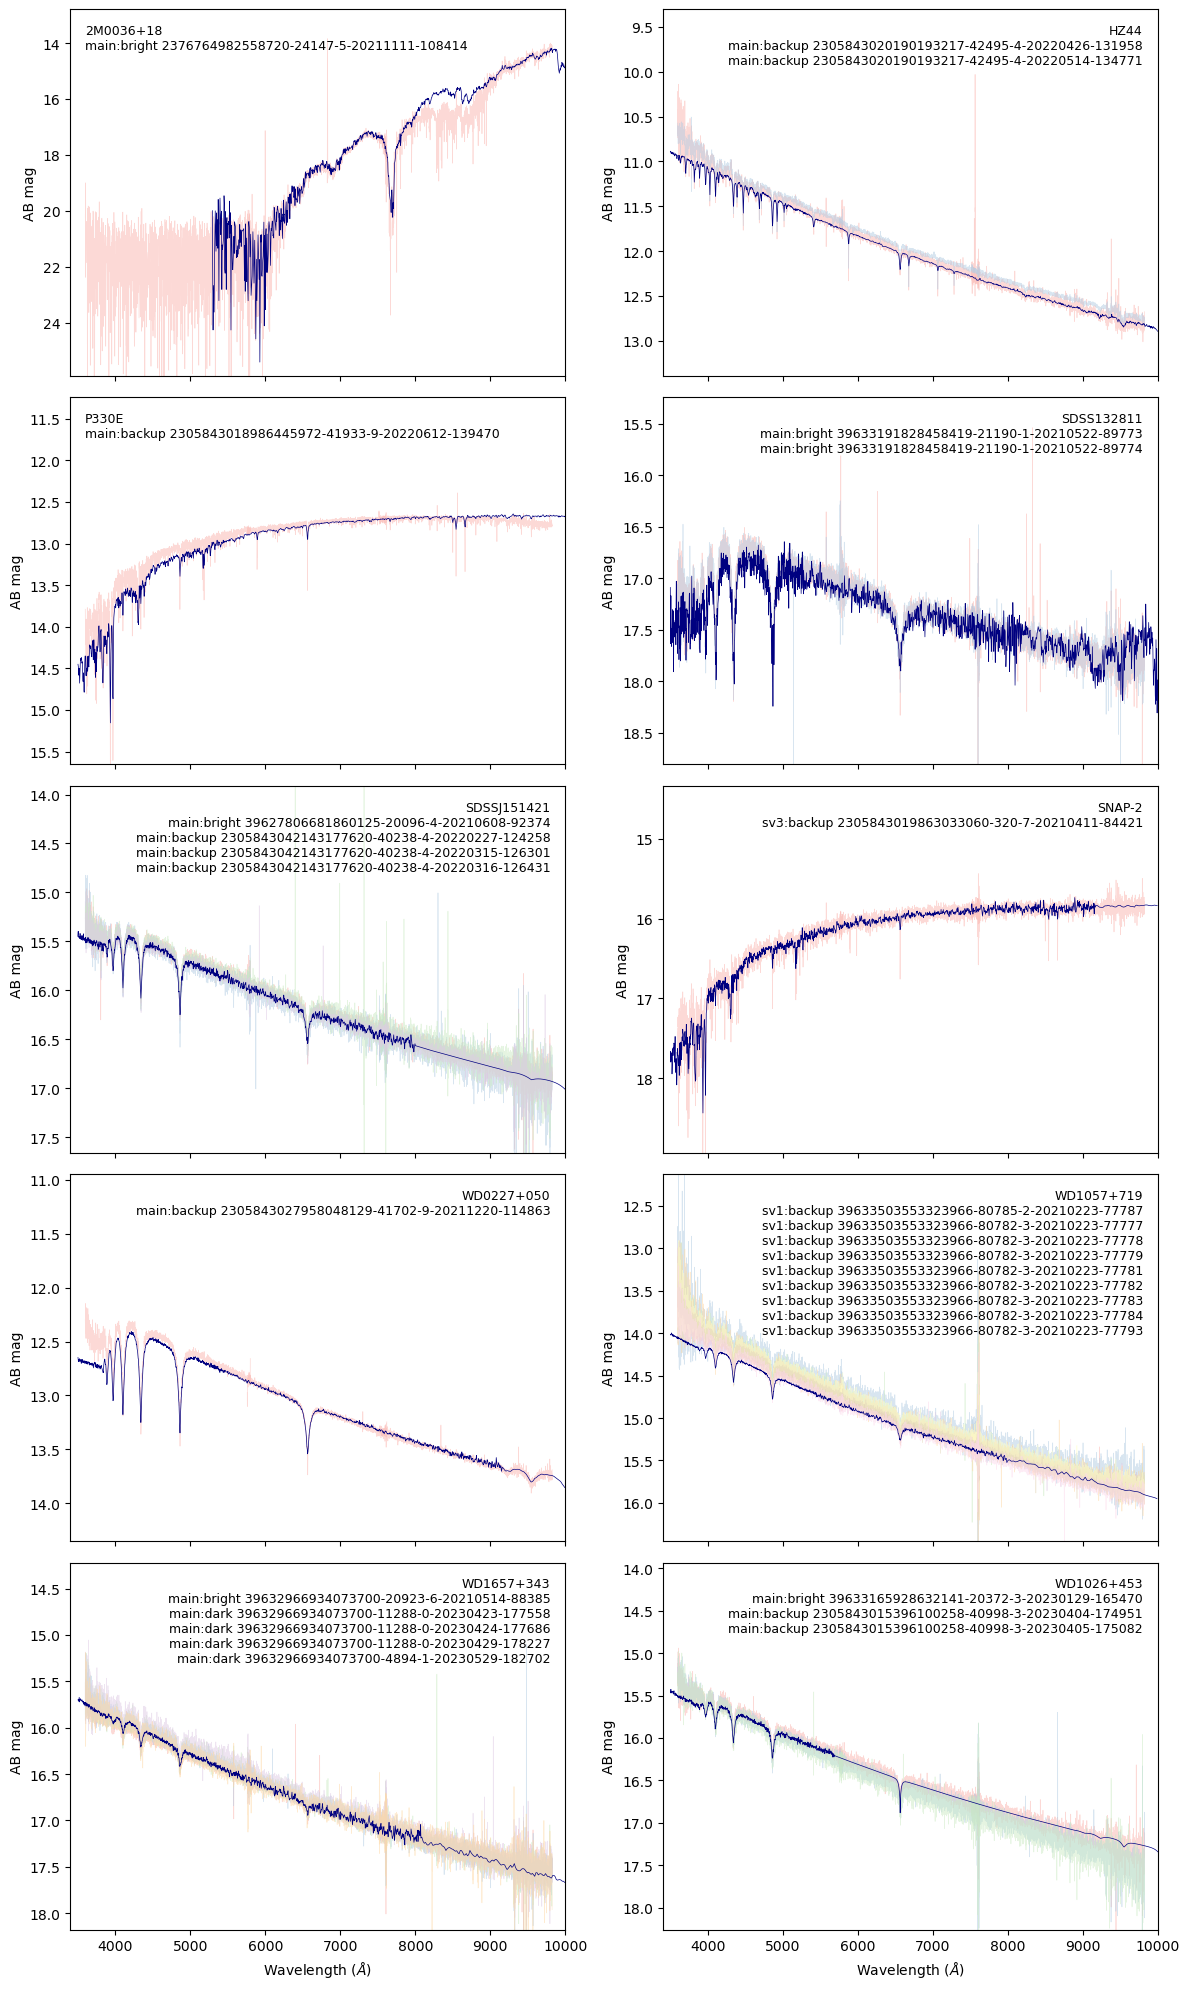

Wrote /pscratch/sd/i/ioannis/calspec-loa/qa-calspec-loa.png


In [157]:
colors = mpl.color_sequences['Pastel1']

qafile = os.path.join(workdir, f'qa-calspec-{specprod}.png')
fig, ax = plt.subplots(5, 2, sharex=True, figsize=(12, 20))

for istar, (obj, xx) in enumerate(zip(sample_exp[I], ax.flat)):

    ylim = [-99, +99]
    label = []
    J = np.where(spec.fibermap['ROW'] == obj['ROW'])[0]
    for ispec, jj in enumerate(J):
        obj1 = sample_exp[jj]
        txt = f'{obj1["SURVEY"]}:{obj1["PROGRAM"]} ' + \
            f'{obj1["TARGETID"]}-{obj1["TILEID"]}-{obj1["PETAL_LOC"]}-{obj1["NIGHT"]}-{obj1["EXPID"]}'
        label.append(txt)
        specwave, specflux, snr, speclim = get_spec(jj, spec)
        #print(obj["STAR_NAME"], snr)
        if snr > 3.:
            if ylim[0] < speclim[0]:
                ylim[0] = speclim[0]
            if ylim[1] > speclim[1]:
                ylim[1] = speclim[1]
            for icam in range(len(specwave)):
                xx.plot(specwave[icam], specflux[icam], alpha=0.5, lw=0.5, color=colors[ispec])
        else:
            print(f'Skipping; low S/N:')
            print(obj1)

    # calspec model
    starfile = get_model_spectra(obj)
    starwave, starflux, starlim = get_star(starfile)
    xx.plot(starwave, starflux, color='navy', lw=0.5)

    if ylim[0] < starlim[0]:
            ylim[0] = starlim[0]
    if ylim[1] > starlim[1]:
        ylim[1] = starlim[1]
    xx.set_ylim(ylim)
    xx.set_ylabel('AB mag')
    #print(obj['STAR_NAME'], ylim)

    label = f'{obj["STAR_NAME"]}\n' + '\n'.join(label)
    if np.any(np.isin(obj['STAR_NAME'], ['2M0036+18', 'SNAP2', 'P330E'])):
        ha = 'left'
        xpos = 0.03
    else:
        ha = 'right'
        xpos = 0.97
    xx.text(xpos, 0.96, label, va='top', ha=ha, 
            fontsize=9, transform=xx.transAxes)

for xx in ax.flat:
    xx.set_xlim(3400, 1e4)
for xx in ax[-1, :]:
    xx.set_xlabel(r'Wavelength ($\AA$)')

fig.tight_layout()
plt.show()
fig.savefig(qafile)
plt.close()
print(f'Wrote {qafile}')